In [1]:
import pandas as pd
import json
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
from pycocotools import mask as maskUtils
import cv2
from ultralytics import YOLO
from sklearn.metrics import jaccard_score
from tqdm import tqdm


In [2]:
file_path = r'metadata_splits.csv'

data = pd.read_csv(file_path)

data = data[['id','file_name','split_open']]

data_types = ['train','valid','test']

datasets ={}
for data_type in data_types:
    datasets[data_type] = data[data['split_open'] == data_type]
# datasets


output_dirs = ['train', 'test', 'valid']

for dir_name in output_dirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

for index, row in data.iterrows():
    source_file = row['file_name']  
    split = row['split_open']  
    
    destination_folder = split  
    destination_path = os.path.join(destination_folder, os.path.basename(source_file))
    

    if os.path.exists(source_file):  
        shutil.move(source_file, destination_path)


In [ ]:
# Load the JSON data
with open('annotations.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)

# Define sets of IDs for train, validation, and test datasets
train_ids = set(datasets['train']['id'])
valid_ids = set(datasets['valid']['id'])
test_ids = set(datasets['test']['id'])

# Function to split COCO data based on given IDs
def split_coco_data(data, ids, split_name):
    
    # Extract and modify the file_name paths in images
    images = [
        {**img, "file_name": f"{os.path.basename(img['file_name'])}"}
        for img in data['images'] if img['id'] in ids
    ]
    
    # Extract corresponding annotations
    annotations = [
        ann for ann in data['annotations'] if ann['image_id'] in ids
    ]

    # Retain the original categories and other metadata
    split_data = {
        'info': data['info'],
        'licenses': data['licenses'],
        'images': images,
        'annotations': annotations,
        'categories': data['categories'],
    }

    return split_data

# Use the split_coco_data function to separate the dataset
train_data = split_coco_data(json_data, train_ids, 'train')
valid_data = split_coco_data(json_data, valid_ids, 'valid')
test_data = split_coco_data(json_data, test_ids, 'test')

# Save the split datasets as JSON files
with open('train.json', 'w') as f:
    json.dump(train_data, f, indent=4)

with open('valid.json', 'w') as f:
    json.dump(valid_data, f, indent=4)

with open('test.json', 'w') as f:
    json.dump(test_data, f, indent=4)

print("Dataset successfully split and saved as train.json, valid.json, and test.json")


Dataset successfully split and saved as train.json, valid.json, and test.json


In [ ]:
def modify_annotations(coco_data):
    """
    Modify COCO annotations based on the logic: carapace = turtle - head - flipper.

    Parameters:
        coco_data: Original COCO data in dictionary format.

    Returns:
        Modified COCO data.
    """
    # Deep copy the data to avoid modifying the original
    new_coco_data = copy.deepcopy(coco_data)

    # Update categories, keeping only carapace, head, and flipper
    new_categories = [
        {'id': 0, 'name': 'carapace'},
        {'id': 1, 'name': 'head'},
        {'id': 2, 'name': 'flipper'}
    ]
    category_name_to_id = {cat['name']: cat['id'] for cat in new_categories}
    new_coco_data['categories'] = new_categories

    # Create a mapping from original category IDs to names
    original_category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Create a new list of annotations
    new_annotations = []
    annotation_id = 1  # Reset annotation ID

    # Process images one by one
    for image_info in tqdm(new_coco_data['images'], desc="Processing images"):
        image_id = image_info['id']
        height = image_info['height']
        width = image_info['width']

        # Get all original annotations for this image
        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        # Initialize masks
        turtle_mask = np.zeros((height, width), dtype=np.uint8)
        head_masks = []
        flipper_masks = []

        # Collect masks for each part and combine turtle masks
        for ann in annotations:
            category_id = ann['category_id']
            category_name = original_category_id_to_name.get(category_id, 'N/A')
            mask = get_mask_from_annotation(ann, height, width)

            # Process masks based on category name
            if category_name == 'turtle':
                turtle_mask = np.maximum(turtle_mask, mask)  # Combine all turtle masks
            elif category_name == 'head':
                head_masks.append(mask)
            elif category_name == 'flipper':
                flipper_masks.append(mask)
            else:
                continue  # Ignore other categories

        # Generate combined mask for head and flipper
        combined_mask = np.zeros((height, width), dtype=np.uint8)
        for head_mask in head_masks:
            combined_mask = np.maximum(combined_mask, head_mask)
        for flipper_mask in flipper_masks:
            combined_mask = np.maximum(combined_mask, flipper_mask)

        # Subtract head and flipper regions from turtle_mask to get carapace
        carapace_mask = np.where(turtle_mask - combined_mask < 0, 0, turtle_mask - combined_mask)

        # Create a new annotation for carapace if there is content in carapace_mask
        if carapace_mask.any():
            rle = maskUtils.encode(np.asfortranarray(carapace_mask))
            rle['counts'] = rle['counts'].decode('ascii')  # 'counts' must be a string
            bbox = maskUtils.toBbox(rle).tolist()
            new_annotations.append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': category_name_to_id['carapace'],
                'segmentation': rle,
                'area': int(carapace_mask.sum()),
                'bbox': bbox,
                'iscrowd': 0
            })
            annotation_id += 1

        # Create individual annotations for each head and flipper
        for mask, category_name in zip(head_masks, ['head'] * len(head_masks)):
            rle = maskUtils.encode(np.asfortranarray(mask))
            rle['counts'] = rle['counts'].decode('ascii')
            bbox = maskUtils.toBbox(rle).tolist()
            new_annotations.append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': category_name_to_id[category_name],
                'segmentation': rle,
                'area': int(mask.sum()),
                'bbox': bbox,
                'iscrowd': 0
            })
            annotation_id += 1

        for mask, category_name in zip(flipper_masks, ['flipper'] * len(flipper_masks)):
            rle = maskUtils.encode(np.asfortranarray(mask))
            rle['counts'] = rle['counts'].decode('ascii')
            bbox = maskUtils.toBbox(rle).tolist()
            new_annotations.append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': category_name_to_id[category_name],
                'segmentation': rle,
                'area': int(mask.sum()),
                'bbox': bbox,
                'iscrowd': 0
            })
            annotation_id += 1

    # Update annotations
    new_coco_data['annotations'] = new_annotations

    return new_coco_data

def get_mask_from_annotation(ann, height, width):
    segmentation = ann['segmentation']
    if isinstance(segmentation, list):
        rles = maskUtils.frPyObjects(segmentation, height, width)
        rle = maskUtils.merge(rles)
        mask = maskUtils.decode(rle)
    elif isinstance(segmentation, dict):
        rle = segmentation
        if isinstance(rle['counts'], list):
            rle = maskUtils.frPyObjects([rle], height, width)[0]
        mask = maskUtils.decode(rle)
    else:
        print(f"Unknown segmentation format, Annotation ID: {ann['id']}")
        mask = np.zeros((height, width), dtype=np.uint8)
    return mask

# Load original data
with open('train.json', 'r', encoding='utf-8') as f1:
    train_data = json.load(f1)
with open('valid.json', 'r', encoding='utf-8') as f2:
    valid_data = json.load(f2)
with open('test.json', 'r', encoding='utf-8') as f3:
    test_data = json.load(f3)

# Modify annotations
modified_train_data = modify_annotations(train_data)
modified_valid_data = modify_annotations(valid_data)
modified_test_data = modify_annotations(test_data)

# Save modified data
with open('modified_train_annotations.json', 'w', encoding='utf-8') as f:
    json.dump(modified_train_data, f)

with open('modified_valid_annotations.json', 'w', encoding='utf-8') as f:
    json.dump(modified_valid_data, f)

with open('modified_test_annotations.json', 'w', encoding='utf-8') as f:
    json.dump(modified_test_data, f)



Processing images: 100%|██████████| 2308/2308 [01:23<00:00, 27.71it/s]


In [ ]:
def rle_to_polygon(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) >= 3:  # At least 3 points are needed to form a polygon
            polygon = contour.flatten().tolist()
            polygons.append(polygon)
    return polygons

def convert_coco_to_yolo_segmentation(coco_data, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create a mapping from image_id to file information
    image_id_to_info = {image['id']: image for image in coco_data['images']}
    
    # Clear existing .txt files to avoid duplicate annotations
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if file_path.endswith(".txt"):
            os.remove(file_path)
    
    # Temporarily store masks for each image and category
    image_masks = {}

    # Create a mapping from category_id to YOLO ID
    category_id_to_yolo_id = {}
    categories = coco_data['categories']
    for idx, category in enumerate(categories):
        category_id_to_yolo_id[category['id']] = idx  # YOLO IDs start from 0

    # Accumulate masks by image and category
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        segmentation = annotation['segmentation']
        image_info = image_id_to_info[image_id]
        height = image_info['height']
        width = image_info['width']
        
        # Initialize mask dictionary for this image if it doesn't exist
        if image_id not in image_masks:
            image_masks[image_id] = {}
        
        # Initialize mask for this category if it doesn't exist
        if category_id not in image_masks[image_id]:
            image_masks[image_id][category_id] = np.zeros((height, width), dtype=np.uint8)
        
        # Process RLE
        if isinstance(segmentation, dict) and 'counts' in segmentation:
            rle = segmentation
            if isinstance(rle['counts'], list):
                # Convert uncompressed RLE to compressed RLE
                rle = maskUtils.frPyObjects([rle], height, width)[0]
        else:
            print(f"Unknown segmentation format, Annotation ID: {annotation['id']}")
            continue
        
        # Decode RLE to binary mask
        mask = maskUtils.decode(rle)
        
        # Accumulate mask
        image_masks[image_id][category_id] = np.maximum(image_masks[image_id][category_id], mask)
    
    # Convert accumulated masks to polygons and write in YOLO format
    for image_id, category_masks in image_masks.items():
        image_info = image_id_to_info[image_id]
        file_basename = os.path.splitext(image_info['file_name'])[0]
        height = image_info['height']
        width = image_info['width']
        
        annotations_list = []
        for category_id, mask in category_masks.items():
            yolo_category_id = category_id_to_yolo_id[category_id]
            # Get polygons from the merged mask
            polygons = rle_to_polygon(mask)
            for polygon in polygons:
                # Normalize polygon coordinates
                normalized_coords = []
                for i in range(0, len(polygon), 2):
                    x = polygon[i] / width
                    y = polygon[i + 1] / height
                    normalized_coords.extend([f"{x:.6f}", f"{y:.6f}"])
                polygon_str = f"{yolo_category_id} " + " ".join(normalized_coords)
                annotations_list.append(f"{polygon_str}\n")
        
        # Write label file
        label_file = os.path.join(output_dir, f"{file_basename}.txt")
        with open(label_file, 'w') as file:
            file.writelines(annotations_list)

# Load JSON files
with open('modified_train_annotations.json', 'r', encoding='utf-8') as f:
    modified_train_data = json.load(f)
with open('modified_valid_annotations.json', 'r', encoding='utf-8') as f:
    modified_valid_data = json.load(f)
with open('modified_test_annotations.json', 'r', encoding='utf-8') as f:
    modified_test_data = json.load(f)

# Convert to YOLO format
convert_coco_to_yolo_segmentation(modified_train_data, 'yolo_seg/yolo_train_labels/labels')
convert_coco_to_yolo_segmentation(modified_valid_data, 'yolo_seg/yolo_valid_labels/labels')
convert_coco_to_yolo_segmentation(modified_test_data, 'yolo_seg/yolo_test_labels/labels')

In [ ]:
def clean_label_files(directory):
    """
    Traverse all .txt files in the directory, and for each file, keep only the last class 0 annotation,
    deleting the others without changing class 1 and class 2 annotations.
    Parameters:
        directory (str): The directory containing the .txt label files.
    """
    # Traverse all .txt files in the specified directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            
            # Read file content
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Record the line numbers of class 0 annotations
            class_0_indices = []
            for idx, line in enumerate(lines):
                stripped_line = line.strip()
                if not stripped_line:
                    continue  # Skip empty lines
                tokens = stripped_line.split()
                if tokens[0] == '0':
                    class_0_indices.append(idx)
            
            # If there are multiple class 0 annotations, keep the last one and delete the others
            indices_to_remove = class_0_indices[:-1]  # Remove all but the last one

            # Build a new list of lines, keeping the order
            new_lines = []
            for idx, line in enumerate(lines):
                if idx not in indices_to_remove:
                    new_lines.append(line)
                else:
                    print(f"Removed line {idx+1} in {filename}: {line.strip()}")
            
            # Write back to the file
            with open(file_path, 'w') as file:
                file.writelines(new_lines)
            
        
# Specify the label files directory
label_directory_train = 'yolo_train_labels/labels'
label_directory_valid = 'yolo_train_labels/labels'
label_directory_test = 'yolo_train_labels/labels'
clean_label_files(label_directory_train)
clean_label_files(label_directory_valid)
clean_label_files(label_directory_test)

In [8]:
# train
model = YOLO('yolov8s-seg.pt')  
model.train(
    data='yolo_seg_config.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    device='cuda'  
)

New https://pypi.org/project/ultralytics/8.3.31 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=yolo_seg_config.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train30, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning D:\UNSW 2024 Term3\9517\Project\yolo_seg\yolo_train_labels\labels.cache... 5302 images, 1 backgrounds, 0 corrupt: 100%|██████████| 5303/5303 [00:00<?, ?it/s]
val: Scanning D:\UNSW 2024 Term3\9517\Project\yolo_seg\yolo_valid_labels\labels.cache... 1118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1118/1118 [00:00<?, ?it/s]


Plotting labels to runs\segment\train30\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train30
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.97G     0.8925      1.342      1.103      1.064         23        640: 100%|██████████| 332/332 [01:30<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  3.89it/s]

                   all       1118       4906      0.796      0.717      0.748      0.559        0.8      0.715      0.744      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.96G      0.868      1.189      0.784      1.035         31        640: 100%|██████████| 332/332 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  3.92it/s]

                   all       1118       4906      0.803        0.7      0.749      0.567      0.812        0.7      0.747       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.99G     0.8484      1.133     0.7361      1.025         27        640: 100%|██████████| 332/332 [01:25<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:10<00:00,  3.41it/s]

                   all       1118       4906      0.816      0.715      0.758      0.579      0.815      0.712       0.75      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.95G     0.7926      1.062     0.6739     0.9984         31        640: 100%|██████████| 332/332 [01:25<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.89it/s]

                   all       1118       4906      0.829      0.726      0.761        0.6      0.829      0.725      0.754      0.593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.94G     0.7246     0.9816     0.6159     0.9716         29        640: 100%|██████████| 332/332 [01:25<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]

                   all       1118       4906      0.842      0.743      0.786      0.624      0.841      0.735      0.774      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.95G      0.694     0.9382     0.5765     0.9544         29        640: 100%|██████████| 332/332 [01:25<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.84it/s]

                   all       1118       4906      0.871      0.747      0.792      0.643      0.881      0.739      0.782      0.624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.95G     0.6498     0.8606     0.5377     0.9378         32        640: 100%|██████████| 332/332 [01:25<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]

                   all       1118       4906      0.889      0.763      0.803      0.665       0.89      0.756      0.797      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.94G     0.6103     0.8149     0.5094     0.9229         30        640: 100%|██████████| 332/332 [01:25<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]

                   all       1118       4906      0.883      0.764      0.811       0.68      0.883      0.761      0.803      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.95G     0.5766     0.7783     0.4818     0.9088         29        640: 100%|██████████| 332/332 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.51it/s]

                   all       1118       4906      0.878      0.772       0.81      0.686      0.883      0.762        0.8      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.94G     0.5459     0.7478     0.4515     0.8966         30        640: 100%|██████████| 332/332 [01:26<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]

                   all       1118       4906      0.892      0.774      0.818        0.7      0.888      0.768      0.807      0.662



10 epochs completed in 0.275 hours.
Optimizer stripped from runs\segment\train30\weights\last.pt, 23.9MB
Optimizer stripped from runs\segment\train30\weights\best.pt, 23.9MB

Validating runs\segment\train30\weights\best.pt...
Ultralytics 8.3.27  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,780,761 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


                   all       1118       4906      0.892      0.774      0.818        0.7      0.888      0.768      0.807      0.662
              carapace       1118       1118      0.761      0.472       0.52      0.422       0.77      0.478      0.503      0.417
                  head       1086       1086      0.979      0.958      0.986      0.864      0.958      0.936      0.971      0.801
               flipper       1105       2702      0.937      0.893      0.948      0.814      0.936       0.89      0.947      0.768
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\segment\train30


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016AD687B750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    

In [9]:
from ultralytics import YOLO


# Test
model = YOLO('runs\\segment\\train30\\weights\\best.pt')  # 使用自定义训练后的权重
results = model.val(data='yolo_seg_config.yaml', split='test', device='cuda', workers=0)



    

Ultralytics 8.3.27  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,780,761 parameters, 0 gradients, 42.4 GFLOPs


val: Scanning D:\UNSW 2024 Term3\9517\Project\yolo_seg\yolo_test_labels\labels.cache... 2306 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2308/2308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/145 [00:00<?, ?it/s]d:\Anaconda3\envs\AI9414\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 145/145 [01:03<00:00,  2.29it/s]


                   all       2308      10148      0.887      0.758        0.8      0.646      0.884      0.752      0.789      0.615
              carapace       2306       2306      0.742      0.425      0.469      0.366      0.757      0.433      0.459      0.377
                  head       2258       2306      0.976      0.941      0.973      0.744      0.954      0.919      0.953      0.693
               flipper       2276       5536      0.942      0.907      0.958      0.828       0.94      0.903      0.954      0.775
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\segment\val38


In [10]:
from ultralytics import YOLO
import cv2

# Test
model = YOLO('D:\\UNSW 2024 Term3\\9517\\Project\\runs\\segment\\train23\\weights\\best.pt')  # 使用自定义训练后的权重
results = model.val(data='yolo_seg_show_config.yaml', split='test', device='cuda', workers=0)

Ultralytics 8.3.27  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,780,761 parameters, 0 gradients, 42.4 GFLOPs


val: Scanning D:\UNSW 2024 Term3\9517\Project\yolo_seg\video_test\labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


                   all          1          4      0.956          1      0.995      0.896      0.956          1      0.995      0.972
              carapace          1          1      0.961          1      0.995      0.895      0.961          1      0.995      0.995
                  head          1          1          1          1      0.995      0.895          1          1      0.995      0.995
               flipper          1          2      0.908          1      0.995      0.895      0.908          1      0.995      0.927
Speed: 0.0ms preprocess, 157.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\segment\val39


Processing Images: 100%|██████████| 8729/8729 [22:02<00:00,  6.60it/s]


Average IoU Scores across all images: {'carapace': 0.01, 'flipper': 0.001, 'head': 0.001}
Mean IoU (mIoU) for each class across all images: {'carapace': 0.01, 'flipper': 0.001, 'head': 0.001}


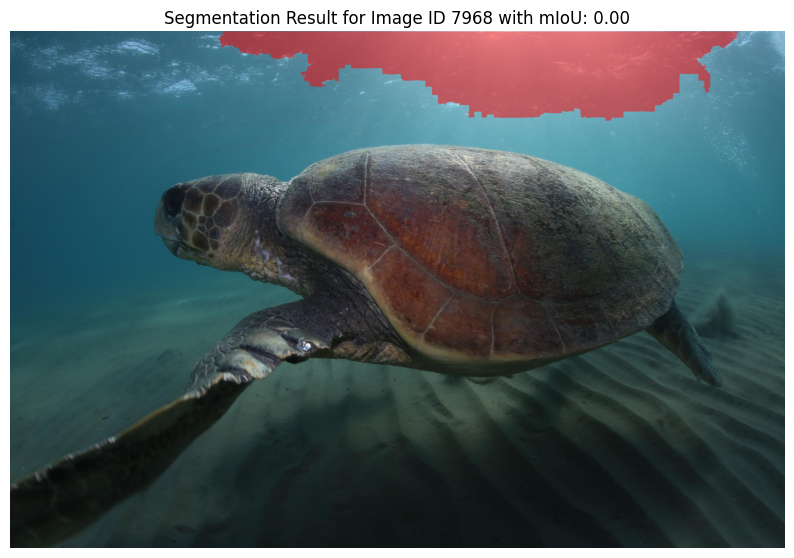

In [5]:
#watershold
json_file_path = 'annotations.json'
image_dir = 'C:\\Users\\59417\\Desktop\\UNSW 2024 Term3\\9517\\Project\\turtles-data\\data'

# load the json
with open(json_file_path, 'r', encoding='utf-8') as f:
    coco_data = json.load(f)

# RLE to masks
def rle_to_mask(rle, height, width):
    if isinstance(rle, dict) and 'counts' in rle:
        if isinstance(rle['counts'], list):
            rle = maskUtils.frPyObjects([rle], height, width)[0]
        mask = maskUtils.decode(rle)
        return mask
    return np.zeros((height, width), dtype=np.uint8)

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou

all_iou_scores = []


visualize_image_id = np.random.choice([img['id'] for img in coco_data['images']])

for image_info in tqdm(coco_data['images'], desc="Processing Images"):
    image_id = image_info['id']
    file_name = image_info['file_name']
    image_path = os.path.join(image_dir, file_name)
    
    # Load the images
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    # 初始化真实掩码
    true_masks = {'carapace': np.zeros((height, width), dtype=np.uint8),
                  'flipper': np.zeros((height, width), dtype=np.uint8),
                  'head': np.zeros((height, width), dtype=np.uint8)}
    
    # 从 JSON 获取真实掩码
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            category_id = annotation['category_id']
            category_name = {0: 'carapace', 1: 'head', 2: 'flipper'}.get(category_id - 1)
            if category_name:
                mask = rle_to_mask(annotation['segmentation'], height, width)
                true_masks[category_name] = np.maximum(true_masks[category_name], mask)
    
  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    
    # watershold
    watershed_masks = {'carapace': np.zeros((height, width), dtype=np.uint8),
                       'flipper': np.zeros((height, width), dtype=np.uint8),
                       'head': np.zeros((height, width), dtype=np.uint8)}
    
    # 
    for label, category_name in zip([2, 3, 4], ['carapace', 'flipper', 'head']):
        watershed_masks[category_name][markers == label] = 1
    
    # 计算每个类别的 IoU 并累积
    iou_scores = {category: calculate_iou(true_masks[category], watershed_masks[category]) for category in true_masks}
    all_iou_scores.append(iou_scores)
    
    # 如果是指定的可视化图片，生成叠加可视化
    if image_id == visualize_image_id:
        overlay = image.copy()
        colors = {'carapace': [0, 0, 255], 'flipper': [0, 255, 0], 'head': [255, 0, 0]}
        for category, mask in watershed_masks.items():
            overlay[mask > 0] = colors[category]
        alpha = 0.5
        result_image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
        
# mIoU
avg_iou_scores = {category: round(np.mean([iou[category] for iou in all_iou_scores]), 3) for category in true_masks}
print("Average IoU Scores across all images:", avg_iou_scores)

# 计算每个类别的 mIoU
class_miou = {category: round(sum(iou[category] for iou in all_iou_scores) / len(all_iou_scores), 3) for category in true_masks}
print("Mean IoU (mIoU) for each class across all images:", class_miou)
# avg_iou_scores = {category: round(np.mean([iou[category] for iou in all_iou_scores]), 3) for category in true_masks}
# miou = round(sum(avg_iou_scores.values()) / len(avg_iou_scores), 3)
# print("Mean IoU (mIoU) across all images:", miou)
# avg_iou_scores, miou
# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f"Segmentation Result for Image ID {visualize_image_id} with mIoU: {miou:.2f}")
plt.axis('off')
plt.show()
